In [ ]:
!pip install missingno

from google.colab import files
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [ ]:
uploaded = files.upload()

Saving OSA_extreme_male.xlsx to OSA_extreme_male.xlsx


In [ ]:
# Specify the file name
file_name = 'OSA_extreme_male.xlsx'

# Read the Excel file into a DataFrame
df_tmp_class = pd.read_excel(file_name)
df_tmp_class.head(5)

,IAH,Weight,Height,Age,PerCervical,Gender,BMI,OSA
0,9.0,80,173,32,40,hombre,26.729927,Healthy
1,2.0,109,190,32,42,hombre,30.193906,Healthy
2,34.0,86,169,39,42,hombre,30.110991,Severe
3,60.0,145,172,47,44,hombre,49.012980,Severe
4,3.7,90,180,36,40,hombre,27.777778,Healthy


## Import Required Libraries:

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Prepare Data

In [ ]:
selected_features = ['BMI', 'Age', 'PerCervical', 'Height', 'Weight']
df_tmp_class_ = df_tmp_class[selected_features]

# Standardizing the data (mandatory for PCA)
scaler = StandardScaler()
df_tmp_class_scaled = scaler.fit_transform(df_tmp_class_)

# Zero mean
print('Features means after normalization \n',
     list(np.mean(df_tmp_class_scaled,axis=0)))

print('\nStandard deviation after normalization \n',
     list(np.std(df_tmp_class_scaled,axis=0)))

Features means after normalization 
 [-9.491983111299048e-17, 6.779987936642177e-18, 3.796793244519619e-16, 6.407088600126858e-16, -2.406895717507973e-16]

Standard deviation after normalization 
 [1.0, 1.0, 1.0, 1.0, 1.0]


## Performing PCA:

In [ ]:
n_components = len(selected_features)
pca = PCA(n_components = n_components)

pca.fit(df_tmp_class_scaled)

PCA(n_components=5)

## Explained Variance Ratio and Visualization:

In [ ]:
# 0,1 denote PC1 and PC2; change values for other PCs
PC1 = pca.components_[0]
PC2 = pca.components_[1]

<BarContainer object of 5 artists>

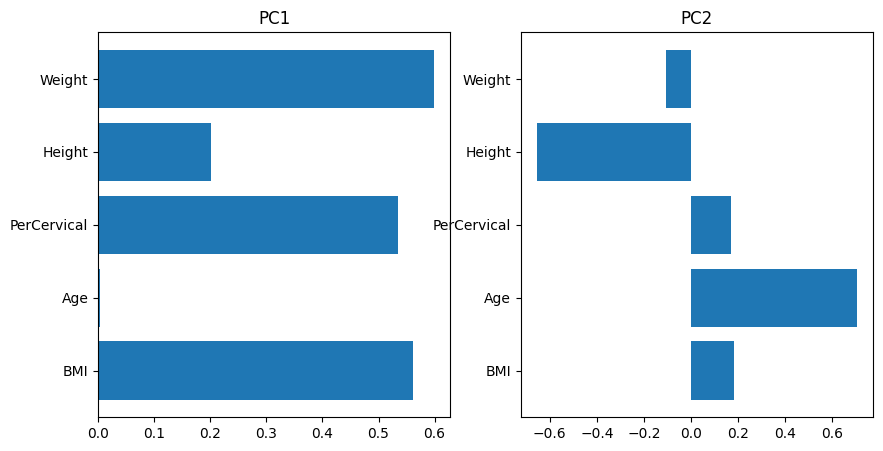

In [ ]:
features = df_tmp_class_.columns
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.barh(features,PC1)
plt.title("PC1")
plt.subplot(122)
plt.title("PC2")
plt.barh(features,PC2)

Explained Variance Ratio: [5.28506032e-01 2.82407631e-01 1.33832172e-01 5.48322528e-02
 4.21912112e-04]
Cumulative Explained Variance: [0.52850603 0.81091366 0.94474584 0.99957809 1.        ]


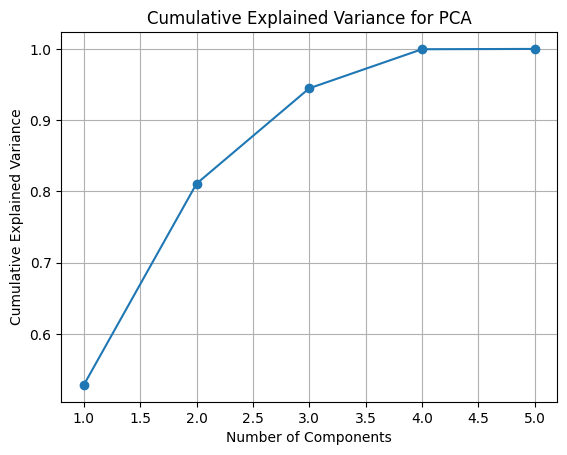

In [ ]:
# Explained variance ratio
explained_var = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_var)

# Cumulative explained variance
cumulative_var = explained_var.cumsum()
print("Cumulative Explained Variance:", cumulative_var)

# Plot the cumulative explained variance
plt.plot(range(1, n_components + 1), cumulative_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for PCA')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Second Principal Component')

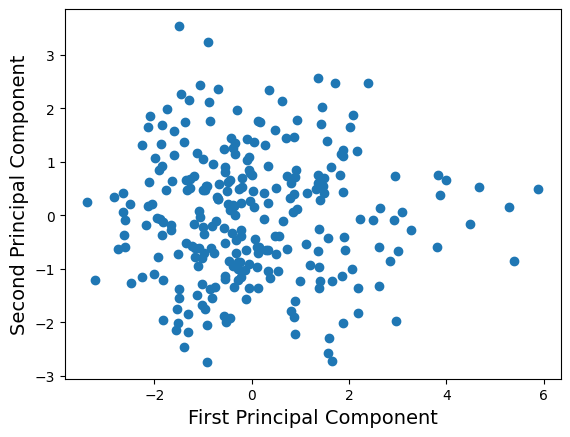

In [ ]:
## project data into PC space
Z1 = pca.transform(df_tmp_class_scaled)[:,0]
Z2 = pca.transform(df_tmp_class_scaled)[:,1]

plt.scatter(Z1,Z2)

plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)

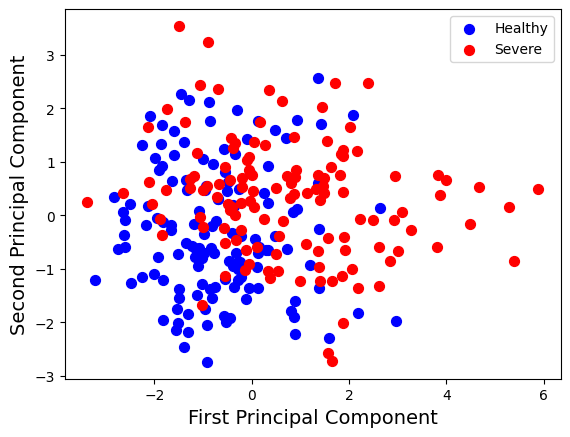

In [ ]:
group = df_tmp_class['OSA']
cdict = {'Severe': 'red', 'Healthy': 'blue'}


fig, ax = plt.subplots()
for g in np.unique(group):
  ix = np.where(group == g)
  ax.scatter(Z1[ix], Z2[ix], c = cdict[g], label = g, s = 50)

plt.xlabel("First Principal Component",fontsize = 14)
plt.ylabel("Second Principal Component",fontsize = 14)
ax.legend()


In [ ]:
coeff = np.transpose(pca.components_[0:2, :])

print(coeff)
print(features)

[[ 0.56232067  0.18250684]
 [ 0.00260794  0.70513424]
 [ 0.53452357  0.16980624]
 [ 0.20045534 -0.65515884]
 [ 0.59823981 -0.10681614]]
Index(['BMI', 'Age', 'PerCervical', 'Height', 'Weight'], dtype='object')


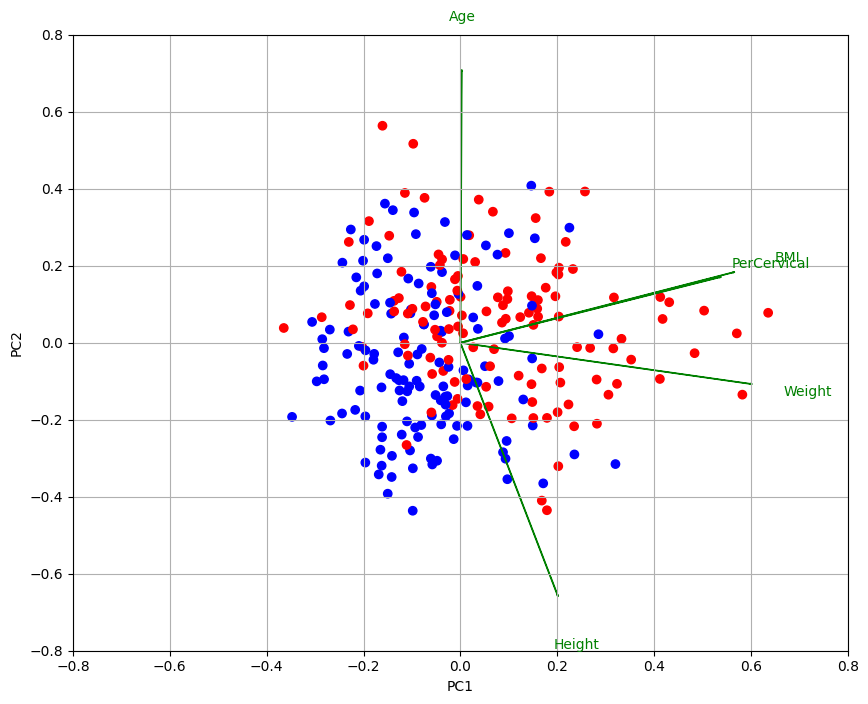

In [ ]:
x_new = pca.transform(df_tmp_class_scaled)

color= ['red' if l == 'Severe' else 'blue' for l in df_tmp_class['OSA']]

def myplot(score,coeff,n_var,labels=None):
    # n_var number of variables to show in biplot
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = color)

    plot_scale = 1.2

    for i in range(n_var):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'g',alpha = 1)
        if labels is None:
            plt.text(coeff[i,0]* plot_scale, coeff[i,1] * plot_scale, features[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* plot_scale, coeff[i,1] * plot_scale, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-0.8,0.8)
    plt.ylim(-0.8,0.8)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
plt.figure(figsize=(10,8))
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]),5)
plt.show()

## Storing the projection we got in an Excel file

In [ ]:
# Assuming Z1 and Z2 are numpy arrays obtained from PCA
Z1 = pca.transform(df_tmp_class_scaled)[:, 0]
Z2 = pca.transform(df_tmp_class_scaled)[:, 1]
Z3 = pca.transform(df_tmp_class_scaled)[:, 2]


# Create a new DataFrame
pca_df = pd.DataFrame({'Z1': Z1, 'Z2': Z2, 'Z3': Z3, 'OSA': df_tmp_class['OSA']})

# Display the first few rows of the new DataFrame
print(pca_df.head())

         Z1        Z2        Z3      OSA
0 -1.163697 -0.779219 -0.912312  Healthy
1  0.897835 -2.227615  0.362919  Healthy
2 -0.413965  0.155920 -1.018871   Severe
3  3.821940  0.745807 -1.664972   Severe
4 -0.545290 -1.187623 -0.196925  Healthy


In [ ]:
pca_df.to_excel("OSA_PCA_extreme_male.xlsx", index = False)

##### K_MEANS

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming pca_df contains features Z1, Z2, Z3, and Cluster columns

# Features used for clustering
features_for_clustering = pca_df[['Z1', 'Z2', 'Z3']]

# Range of K values to try
k_values = range(2, 11)

# Dictionary to store silhouette scores for each K
silhouette_scores = {}

# Loop through each K value and compute silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans.fit_predict(features_for_clustering)
    silhouette_avg = silhouette_score(features_for_clustering, cluster_labels)
    silhouette_scores[k] = silhouette_avg

# Find the K with the highest silhouette score
best_k = max(silhouette_scores, key=silhouette_scores.get)

# Print the silhouette scores
for k, score in silhouette_scores.items():
    print(f'K = {k}: Silhouette Score = {score:.4f}')

print(f'Best K: {best_k} (Silhouette Score = {silhouette_scores[best_k]:.4f})')

K = 2: Silhouette Score = 0.3394
K = 3: Silhouette Score = 0.2802
K = 4: Silhouette Score = 0.2629
K = 5: Silhouette Score = 0.2730
K = 6: Silhouette Score = 0.2732
K = 7: Silhouette Score = 0.2821
K = 8: Silhouette Score = 0.2779
K = 9: Silhouette Score = 0.2733
K = 10: Silhouette Score = 0.2694
Best K: 2 (Silhouette Score = 0.3394)


In [ ]:
from sklearn.cluster import KMeans

# Assuming pca_df contains Z1 and Z2 columns
X_pca = pca_df[['Z1', 'Z2', 'Z3']]

# Specify the number of clusters (adjust as needed)
num_clusters = best_k

# Create and fit the K-means model
kmeans = KMeans(n_clusters = 2, random_state = 42)
kmeans.fit(X_pca)

# Add cluster labels to the pca_df DataFrame
pca_df['Cluster'] = kmeans.labels_

# Display the resulting DataFrame with cluster labels
print(pca_df.head())

         Z1        Z2        Z3      OSA  Cluster
0 -1.163697 -0.779219 -0.912312  Healthy        0
1  0.897835 -2.227615  0.362919  Healthy        1
2 -0.413965  0.155920 -1.018871   Severe        0
3  3.821940  0.745807 -1.664972   Severe        1
4 -0.545290 -1.187623 -0.196925  Healthy        0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


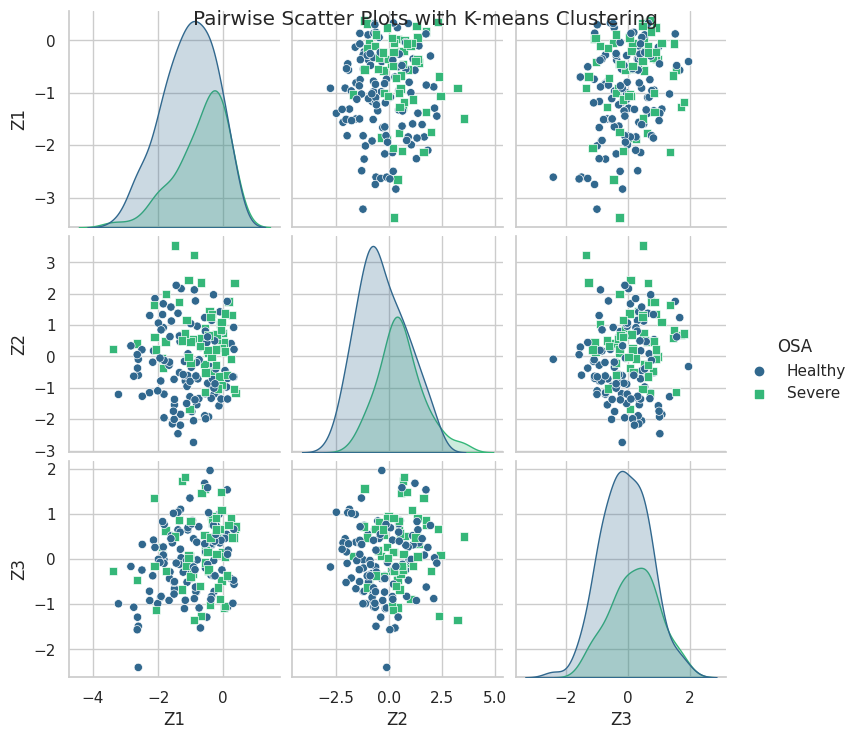

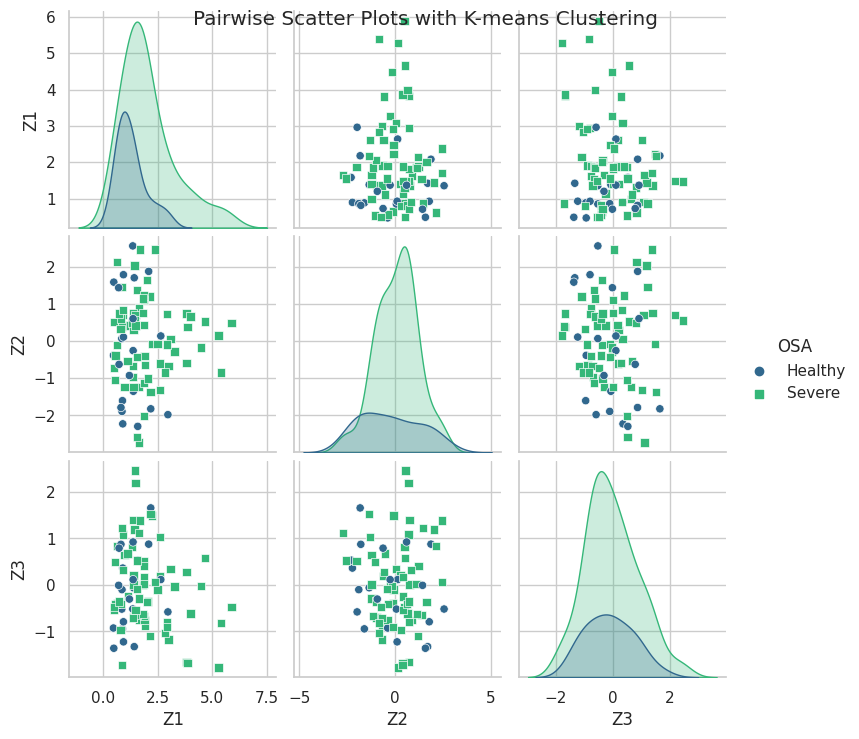

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming pca_df contains OSA, Z1, Z2, Z3, and Cluster columns
for i in range(2):
  sns.pairplot(pca_df.groupby('Cluster').get_group(i), hue = 'OSA', vars = ['Z1', 'Z2', 'Z3'], palette = 'viridis', markers = ['o', 's'])
  plt.suptitle('Pairwise Scatter Plots with K-means Clustering')
  plt.show()

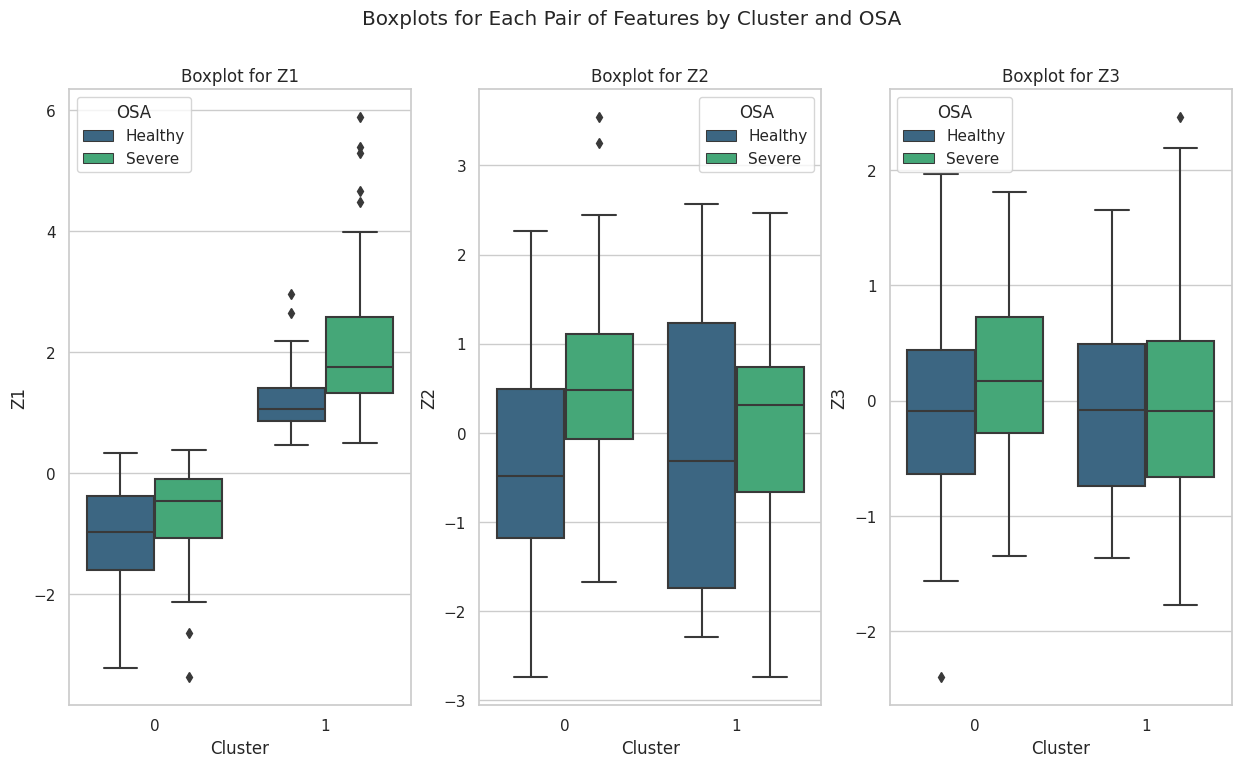

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming pca_df contains OSA, Z1, Z2, Z3, and Cluster columns
sns.set(style = "whitegrid")
plt.figure(figsize = (15, 8))

# Loop through each pair of features
for i, feature in enumerate(['Z1', 'Z2', 'Z3']):
    plt.subplot(1, 3, i + 1)

    # Create a boxplot for each feature, grouped by Cluster and colored by OSA
    sns.boxplot(x = 'Cluster', y = feature, hue = 'OSA', data = pca_df, palette = 'viridis')

    # Set plot labels and title
    plt.title(f'Boxplot for {feature}')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.suptitle('Boxplots for Each Pair of Features by Cluster and OSA')
plt.show()